In [1]:
import binascii
import time
import os
import shutil
import numpy
import fobos
WORKSPACE = "/home/xilinx/fobosworkspace"
PROJECT_NAME ="aes_test"
DIN_FILE_NAME = "dinFile.txt"
CIPHER_FILE = "ciphertext.txt"
TRACE_FILE = "powerTrace.npy"
DUT_BIT_FILE = "FOBOS_DUT.bit"
TRACE_NUM = 10
OUT_LEN = 16

#program DUT


#Scope ########################################################################################################
scopConfig = {
         'OSCILLOSCOPE'       : 'AGILENT', #AGILENT|OPENADC
         'OSCILLOSCOPE_IP'    : '192.168.10.10',
         'OSCILLOSCOPE_PORT'  : '5025',
         'AUTOSCALE'          : 'NO',   # YES|NO    
         'IMPEDANCE'          : 'ONEMEG', #FIFTY|ONEMEG
         # VOLTAGE AND TIME RANGE OPTIONS        
         'CHANNEL1_RANGE'     : '0.100V',
         'CHANNEL2_RANGE'     : '6V',
         'CHANNEL3_RANGE'     : 'OFF', # ON|OFF|voltage range
         'CHANNEL4_RANGE'     : 'OFF', # ON|OFF|voltage range
         'TIME_RANGE'         :  '0.000040',
         'TIMEBASE_REF'       : 'LEFT',    
         # TRIGGER OPTIONS
         'TRIGGER_SOURCE'     : 'CHANNEL2',
         'TRIGGER_MODE'       : 'EDGE',   
         'TRIGGER_SWEEP'      : 'NORM',
         'TRIGGER_LEVEL'      : '0.5',
         'TRIGGER_SLOPE'      : 'POSITIVE',
         # ACQUIRE OPTIONS
         'ACQUIRE_TYPE'       : 'NORM', # NORM|PEAK|HRES|AVER
         'ACQUIRE_MODE'       : 'RTIM'   # RTIM | ETIM| SEG
}
#scope = fobos.Scope()
#scope.setConfig(scopConfig)
#print(scope.getConfig())
#scope.openConnection()
#scope.applyConfig()



In [2]:
#dutcomm register offsets
dutcomm_START       = 0x00
dutcomm_STATUS      = 0x04
dutcomm_EXP_OUT_LEN = 0x0c
##########################
#dutctrl register offsets
dutctrl_TRGLEN     = 0x00
dutctrl_TRGWIAT    = 0x04
dutctrl_TRGMODE    = 0x08
#trigger settings
TRG_NORM            = 0X00
TRG_FULL            = 0x01
TRG_NORM_CLK        = 0x02
TRG_FULL_CLK        = 0x03
##########################
#config parameters
OUT_LEN    = 4  # in 32 bit words
TV_LEN              = 12 # in 32 bit words

##########################
import pynq.lib.dma
from pynq import Xlnk
import numpy as np
from pynq import Overlay
import sys
import time
##########################
ol = Overlay("ctrl_top_wrapper.bit")
xlnk = Xlnk()
dma = ol.axi_dma_0
help(ol)

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


Help on Overlay in module pynq.overlay object:

class Overlay(pynq.pl.Bitstream)
 |  This class keeps track of a single bitstream's state and contents.
 |  
 |  The overlay class holds the state of the bitstream and enables run-time
 |  protection of bindlings.
 |  
 |  Our definition of overlay is: "post-bitstream configurable design".
 |  Hence, this class must expose configurability through content discovery
 |  and runtime protection.
 |  
 |  The overlay class exposes the IP and hierarchies as attributes in the
 |  overlay. If no other drivers are available the `DefaultIP` is constructed
 |  for IP cores at top level and `DefaultHierarchy` for any hierarchies that
 |  contain addressable IP. Custom drivers can be bound to IP and hierarchies
 |  by subclassing `DefaultIP` and `DefaultHierarchy`. See the help entries
 |  for those class for more details.
 |  
 |  This class stores four dictionaries: IP, GPIO, interrupt controller
 |  and interrupt pin dictionaries.
 |  
 |  Each ent

/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


In [3]:
wiz = ol.clk_wiz
wiz.write(0x200, 0x00000102)
wiz.write(0x208, 0x0000007d)
wiz.write(0x25c, 0x00000003)

dutcomm = ol.dutcomm_0
#dutcomm.read(dutcomm_STATUS)
dut_ctrl = ol.dut_controller_0
#clk_divider = ol.clock_divider_0


In [4]:
#configure dutcomm expected_output_lenght
dutcomm = ol.dutcomm_0
dutcomm.write(dutcomm_EXP_OUT_LEN,4)
#set trigger to full
dut_ctrl.write(dutctrl_TRGMODE, TRG_FULL)
#clk_divider.write(0, 0xFFFFFFFF)


In [5]:
#test vector
tv = [0x00c00010, 0x59390499, 0x79b065ad, 0x57f2548b, 0x2b539aa1, 
      0x00c10010, 0x11352d06, 0xd4fc0fb3, 0xc0fda1b8, 0x94d8aa1f,
      0x00810010, 0x00800001]

In [6]:
#scope.arm()

In [8]:
##########################
###configure worksapce
pm = fobos.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(PROJECT_NAME)
projDir = pm.getProjDir()
##########################
dut = fobos.Nexys3DUT()
bitFile = os.path.join(projDir, DUT_BIT_FILE)
dut.setBitFile(bitFile)
dut.program()
tvFileName = os.path.join(projDir, DIN_FILE_NAME)
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
cipherFileName = os.path.join(captureDir, CIPHER_FILE)
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, TRACE_FILE)
traceFile = open(traceFileName, "a+b")
shutil.copy(tvFileName, captureDir)
#########################
TRACE_NUM = 10
tic = time.time()
input_buffer = xlnk.cma_array(shape=(TV_LEN,), dtype=np.uint32)
output_buffer = xlnk.cma_array(shape=(OUT_LEN,), dtype=np.uint32)
scope.arm()
time.sleep(1)
lines = tvFile.readlines()
for traceNum in range(TRACE_NUM):
    #get one line of dinFile and convert every 8 characters into 32bit int
    #interpret data as hex
    line = lines[traceNum].strip()
    tv = [int(line[i:i+8],16) for i in range(0, len(line), 8)]
    time.sleep(0.05) #this delay seem to be needed
    for i in range(0, TV_LEN):
       input_buffer[i] = tv[i]
    
    dma.recvchannel.transfer(output_buffer) #configure dma to receive
    dma.sendchannel.transfer(input_buffer)  #configure dma to send 
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    #get trigger once to use it to align
    if traceNum == 0:
        #trigTrace = scope.readChannel('CHAN2')
        #print(trigTrace)
        #start, end = scope.getCutPoints(trigTrace)
        #print("Cutting trace parameters: start=%d, end = %d" % (start, end))
    #trace = scope.readChannel('CHAN1')[start:end]
    #print(trace.shape)
    #trace = trace[start:end]
    #if traceNum != TRACE_NUM - 1: #after you finish do not arm scope. It will hang
        #scope.arm()
    #covert 32 bit int array into string
    result = ''.join(['{:08x}'.format(output_buffer[i]) for i in range(0, 4)])
    cipherFile.write(result + '\n')
    #numpy.save(traceFile, trace)
    if traceNum % 10 == 0:
        sys.stdout.write("Progress: %d\r" % (traceNum/TRACE_NUM *100 ))
        sys.stdout.flush()
    #time.sleep(1)

input_buffer.freebuffer()
output_buffer.freebuffer()
cipherFile.close()
tvFile.close()
traceFile.close()
    
toc = time.time()
print("Time elapsed = {} seconds.".format(toc - tic))

Programming device using the following commands:
sudo -u xilinx djtgcfg init -d Nexys3
sudo -u xilinx djtgcfg prog -d Nexys3 -i 0 -f /home/xilinx/fobosworkspace/aes_test/FOBOS_DUT.bit
b'Programming device. Do not touch your board. This may take a few minutes...\nProgramming succeeded.\n'
Successfully created new capture directory at /home/xilinx/fobosworkspace/aes_test/capture/attempt-1
Cutting trace parameters: start=1999, end = 18998
Time elapsed = 5.442733526229858 seconds.


/home/xilinx/fobosworkspace/aes_test/capture/attempt-1/powerTrace.npy
(16999,)


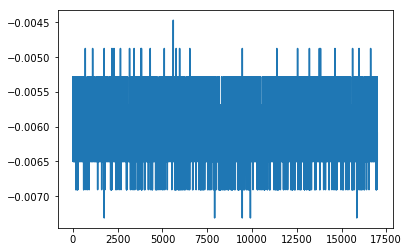

In [9]:
import matplotlib.pyplot as plt
f = open(traceFileName, 'rb')
print(traceFileName)
dataToPlot = numpy.load(f)
plt.plot(dataToPlot)
print(dataToPlot.shape)
plt.show()

1999
18998


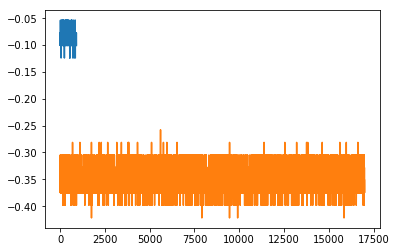

In [10]:

print(start)
print(end)
plt.plot(trigTrace[43:950])
plt.plot((750/13)*dataToPlot)
plt.show()



In [ ]:
pl